# Model Training on Structured Data

In [1]:
# importing libraries

import pandas as pd
import numpy as np
import tensorflow as tf
import os 
# for some models GPU capacity was not enough hence trained those models by disabling GPU with below line
os.environ["CUDA_VISIBLE_DEVICES"]="-1"
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle
from tensorflow.keras.layers import Dense,Flatten,Embedding,Concatenate
from tensorflow.keras.layers import Conv1D,MaxPooling1D,Dropout,Conv2D,MaxPooling2D
from tensorflow.keras.layers import Input,Activation,LSTM,BatchNormalization
from tensorflow.keras.models import Model
from sklearn.preprocessing import Normalizer
from sklearn.metrics import roc_curve,roc_auc_score,f1_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm
from sklearn.preprocessing import minmax_scale,MinMaxScaler
import tensorflow_text as text
import pathlib
import tensorflow_addons as tfa

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.4.0 and strictly below 2.7.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.7.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [2]:
# reading preprocessed data

structured_data = pickle.load(open("structured_data.pkl","rb"))
print("Shape of created dataframe is : ",structured_data.shape)
print("Shape of created featrure matrix in feat_mat column is : ",structured_data['feat_mat'].values[1].shape)

Shape of created dataframe is :  (10956, 6)
Shape of created featrure matrix in feat_mat column is :  (500, 310, 1)


In [3]:
# for missing data for any company, on a particular day, was assigned 0 as sign change label
# hence removing those to have cleaned data
# structured_data = structured_data[structured_data.sign_change != 0]


# changing -1 & 1 to 0 & 1 to have binary crossentropy as loss and sigmoid as final layer activation.
# structured_data['sign_change'] = structured_data.sign_change.apply(lambda x:0 if x==-1 else 1)

structured_data.head()

,post_date,tweet_text,company_name,feat_mat,change_label,sign_change
0,2015-01-01,aapl store line sapporo japan lucky bag pic ht...,AAPL,"[[[0.0031695721077654], [0.0020060180541624], ...",0.000000,1
1,2015-01-02,algo good game right attack aapl let everythin...,AAPL,"[[[0.0015847860538827], [0.0090270812437311], ...",0.951259,0
2,2015-01-03,hedge fund heat map apple aaplcheck 100 top pe...,AAPL,"[[[0.0], [0.0010030090270812], [0.003003003003...",0.000000,1
3,2015-01-04,else going tech apple aapl viawall street top ...,AAPL,"[[[0.0], [0.0], [0.002002002002002], [1.0], [0...",0.000000,1
4,2015-01-05,aapl breached 100 day got ppl stopped trying b...,AAPL,"[[[0.0015847860538827], [0.0040120361083249], ...",2.817159,0


In [4]:
structured_data['sign_change'].unique()

array([1, 0], dtype=object)

In [5]:
# Sorting the dataframe to simplify the vizualisation of dataframe

structured_data = structured_data.sort_values(by=['post_date','company_name'])
structured_data.head(15)

,post_date,tweet_text,company_name,feat_mat,change_label,sign_change
0,2015-01-01,aapl store line sapporo japan lucky bag pic ht...,AAPL,"[[[0.0031695721077654], [0.0020060180541624], ...",0.000000,1
1826,2015-01-01,aapl store line sapporo japan lucky bag pic ht...,AMZN,"[[[0.0031695721077654], [0.0020060180541624], ...",0.000000,1
9130,2015-01-01,aapl store line sapporo japan lucky bag pic ht...,GOOG,"[[[0.0031695721077654], [0.0020060180541624], ...",0.000000,1
3652,2015-01-01,aapl store line sapporo japan lucky bag pic ht...,GOOGL,"[[[0.0031695721077654], [0.0020060180541624], ...",0.000000,1
7304,2015-01-01,aapl store line sapporo japan lucky bag pic ht...,MSFT,"[[[0.0031695721077654], [0.0020060180541624], ...",0.000000,1
5478,2015-01-01,aapl store line sapporo japan lucky bag pic ht...,TSLA,"[[[0.0031695721077654], [0.0020060180541624], ...",0.000000,1
1,2015-01-02,algo good game right attack aapl let everythin...,AAPL,"[[[0.0015847860538827], [0.0090270812437311], ...",0.951259,0
1827,2015-01-02,algo good game right attack aapl let everythin...,AMZN,"[[[0.0015847860538827], [0.0090270812437311], ...",0.589657,0
9131,2015-01-02,algo good game right attack aapl let everythin...,GOOG,"[[[0.0015847860538827], [0.0090270812437311], ...",0.302052,0
3653,2015-01-02,algo good game right attack aapl let everythin...,GOOGL,"[[[0.0015847860538827], [0.0090270812437311], ...",0.209173,0


<li> As data is already arranged in model training format, we do not need to process it further, we can directly use this data for training after being split in train and validation datasets. </li>
<li> Since we have temporal information in data and hence we can consider information till a timestamp to train and data after that timestamp for validation. </li>
<li> Here, the data is present from 1st Jan 2015 to 31st Dec 2019, so what we can do it consider 4 years, 6 months of data for training while 6 months of data for validation.  </li>
<li> The data is split in train and validation in next cell. </li>

In [6]:
# the data that we have is from '2015-01-01' to '2019-12-31'
# Hence taking last 6 months as test data and 4 years, 6 months of training data from the dataset
train_data = structured_data[structured_data.post_date < '2019-06-01']
test_data = structured_data[structured_data.post_date >= '2019-06-01']


# getting train data for all models
# two class labels are there, one is magnitude of % change
# while second one is sign of change (values 0 or 1 : 0 - negative change, 1 - positive change)
y_train_change = train_data['change_label'].values
y_train_sign = train_data['sign_change'].values
y_train_sign = y_train_sign.astype('int')
x_train_text = train_data['tweet_text'].values
'''x_train_tweet_vec = train_data['tweet_vec'].values
x_train_tweet_vec = list(x_train_tweet_vec)
x_train_tweet_vec = np.array(x_train_tweet_vec)'''
x_train_feat = list(train_data['feat_mat'].values)
x_train_feat = np.array(x_train_feat)
x_train_company = train_data['company_name'].values

# getting test data for all models
y_test_change = test_data['change_label'].values
y_test_sign = test_data['sign_change'].values
y_test_sign = y_test_sign.astype('int')
x_test_text = test_data['tweet_text'].values
'''x_test_tweet_vec = test_data['tweet_vec'].values
x_test_tweet_vec = list(x_test_tweet_vec)
x_test_tweet_vec = np.array(x_test_tweet_vec)'''
x_test_feat = list(test_data['feat_mat'].values)
x_test_feat = np.array(x_test_feat)
x_test_company = test_data['company_name'].values



print("Number of data points in train data are :",train_data.shape[0])
print("Number of data points in train data are :",test_data.shape[0])

Number of data points in train data are : 9672
Number of data points in train data are : 1284


<li> Now that we have train and test sets, let us proceeed with model training. </li>

In [7]:
print("Unique Companies in Train data are : ",train_data['company_name'].unique())
print("Unique Companies in Test data are  : ",test_data['company_name'].unique())

Unique Companies in Train data are :  ['AAPL' 'AMZN' 'GOOG' 'GOOGL' 'MSFT' 'TSLA']
Unique Companies in Test data are  :  ['AAPL' 'AMZN' 'GOOG' 'GOOGL' 'MSFT' 'TSLA']


### Tokenizing tweet text with  BertTokenizer and Company name Column with simple Tokenizer

In [8]:
# referred below link to implement subword tokenizer
# https://www.tensorflow.org/text/guide/subwords_tokenizer

bert_tokenizer_params=dict(lower_case=True)
reserved_tokens=[]

bert_vocab_args = dict(
    # The target vocabulary size
    vocab_size = 8000,
    # Reserved tokens that must be included in the vocabulary
    reserved_tokens=reserved_tokens,
    # Arguments for `text.BertTokenizer`
    bert_tokenizer_params=bert_tokenizer_params,
    # Arguments for `wordpiece_vocab.wordpiece_tokenizer_learner_lib.learn`
    learn_params={},
)

# creating BertTokenizer object with vocab text file genrated as per reference link stated above
en_tokenizer = text.BertTokenizer('en_vocab.txt', **bert_tokenizer_params)
vocab_size_text = len(pathlib.Path('en_vocab.txt').read_text().splitlines())+ 1


# Using BertTokenizer to tokenize train data
encoded_text = en_tokenizer.tokenize(x_train_text)
encoded_text = encoded_text.merge_dims(-2,-1)   # reducing dimension of ragged tensor
encoded_text = encoded_text.to_list()           # converting to list to pad the sequences
max_length = 5000                               # max length of padding
train_text = pad_sequences(encoded_text, maxlen=max_length, padding='post')


# Using BertTokenizer to tokenize test data 
encoded_text = en_tokenizer.tokenize(x_test_text)
encoded_text = encoded_text.merge_dims(-2,-1)
encoded_text = encoded_text.to_list()
test_text = pad_sequences(encoded_text, maxlen=max_length, padding='post')



# saving tokenizer output so that there won't be any need to recalculate this for every execution
pickle.dump([vocab_size_text,train_text,test_text],open("bert_tokens.pkl","wb"))

In [8]:
# loading saved tokenizer output

[vocab_size_text,train_text,test_text] = pickle.load(open("bert_tokens.pkl","rb"))

#### Company name has to be provided as input since for each datapoint since social media may behave differently for each company. Hence company name is provided to each model through an embedding layer. This is not stated in model title but in structure it is provided as an input

In [9]:
# We don't need to use subwordtokenizer here since these company names are standard
# and these will not be changed while giving as inputs


# creating tokens for company names
tokenizer = Tokenizer()                   # creating tokenizer object
tokenizer.fit_on_texts(x_train_company) 
vocab_size_company = len(tokenizer.word_index) + 1

# getting tokenized train data
train_comp = np.array(tokenizer.texts_to_sequences(x_train_company))

# getting tokenized test data
test_comp = np.array(tokenizer.texts_to_sequences(x_test_company))

In [ ]:
pickle.dump(tokenizer,open("tokenizer.pkl","wb"))

## 1. Base model trained with just Combined Tweet Text Data

<li> This model will be trained with just combined tweet text and Feature Matrix data will not be used here. </li>
<li> Since Feature Matrix is not used here in any manner, This will be considered as the base model and all other models are expected to perform better than this model. </li>

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint

filepath="model2_save/weights-{epoch:02d}-{val_loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss',  verbose=1, save_best_only=True, mode='auto')

In [11]:
np.random.seed(0)
tf.random.set_seed(0)

# clearing previous session if it exists.
tf.keras.backend.clear_session()

# essay feature
input_text = Input(shape=(5000,),name="Tweet text input")

embedding_text = Embedding(vocab_size_text, 100)(input_text)

conv1 = Conv1D(64,kernel_size = 20)(embedding_text)

maxpool1 = MaxPooling1D(10)(conv1)

flatten1 = Flatten()(maxpool1)


input_company = Input(shape=(1,),name="Company_name")

embedding_company = Embedding(vocab_size_company, 6)(input_company)

flatten2 = Flatten()(embedding_company)

concat = Concatenate()([flatten1,flatten2])

dense_layer1 = Dense(50,activation='relu',kernel_initializer=tf.keras.initializers.he_uniform())(concat)

dense_layer2 = Dense(50,activation='relu',kernel_initializer=tf.keras.initializers.he_uniform())(dense_layer1)

dense_layer41 = Dense(50,activation='relu',kernel_initializer=tf.keras.initializers.he_uniform())(dense_layer2)

dense_layer41 = Dense(50,activation='relu',kernel_initializer=tf.keras.initializers.he_uniform())(dense_layer41)

output_sign = Dense(1,activation = 'sigmoid',name="sign_prediction")(dense_layer41)

dense_layer42 = Dense(50,activation='relu',kernel_initializer=tf.keras.initializers.he_uniform())(dense_layer2)

dense_layer42 = Dense(50,activation='relu',kernel_initializer=tf.keras.initializers.he_uniform())(dense_layer42)

output_change = Dense(1,activation='relu',name="Change_prediction")(dense_layer42)


model = Model(inputs=[input_text,input_company]
              ,outputs=[output_change,output_sign])

# compiling with adam optimizer and loss as categorical crossentropy
model.compile(optimizer=tf.keras.optimizers.Adam(0.0001),
              loss=[tf.keras.losses.mean_squared_error,tf.keras.losses.binary_crossentropy])

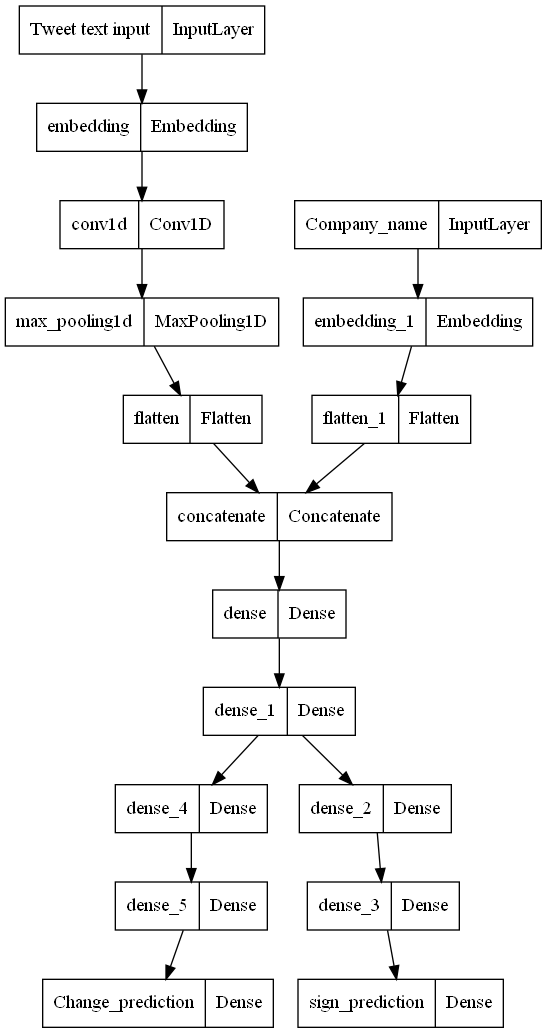

In [12]:
# Plotting model with text input and two outputs
tf.keras.utils.plot_model(model,to_file='base_model.png')

In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Tweet text input (InputLayer)  [(None, 5000)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 5000, 100)    701100      ['Tweet text input[0][0]']       
                                                                                                  
 conv1d (Conv1D)                (None, 4981, 64)     128064      ['embedding[0][0]']              
                                                                                                  
 Company_name (InputLayer)      [(None, 1)]          0           []                               
                                                                                              

In [18]:
# Training the model

model.fit([train_text,train_comp],[y_train_change,y_train_sign],
          epochs=5,validation_data=([test_text,test_comp],[y_test_change,y_test_sign]),
         callbacks=[log_info,checkpoint])

Epoch 1/5
303/303 [==============================] - ETA: 0s - loss: 2.0746 - Change_prediction_loss: 1.4675 - sign_prediction_loss: 0.6071
Epoch 00001: val_loss improved from inf to 2.36744, saving model to model2_save\weights-01-2.3674.hdf5
303/303 [==============================] - 30s 76ms/step - loss: 2.0746 - Change_prediction_loss: 1.4675 - sign_prediction_loss: 0.6071 - val_loss: 2.3674 - val_Change_prediction_loss: 1.7150 - val_sign_prediction_loss: 0.6524
Epoch 2/5
302/303 [============================>.] - ETA: 0s - loss: 1.9075 - Change_prediction_loss: 1.3170 - sign_prediction_loss: 0.5904- ETA: 3s - loss: 1.9368 - Change_prediction_lo
Epoch 00002: val_loss improved from 2.36744 to 2.24049, saving model to model2_save\weights-02-2.2405.hdf5
303/303 [==============================] - 22s 74ms/step - loss: 1.9069 - Change_prediction_loss: 1.3164 - sign_prediction_loss: 0.5905 - val_loss: 2.2405 - val_Change_prediction_loss: 1.5884 - val_sign_prediction_loss: 0.6521
Epoch 3/5

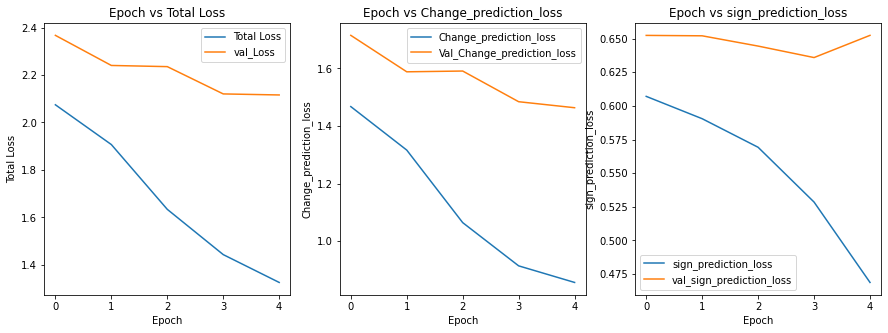

In [19]:
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.plot(log_info.loss,label='Total Loss')
plt.plot(log_info.val_loss,label='val_Loss')
plt.xlabel("Epoch")
plt.ylabel("Total Loss")
plt.title("Epoch vs Total Loss")
plt.legend()

plt.subplot(132)
plt.plot(log_info.Change_prediction_loss,label='Change_prediction_loss')
plt.plot(log_info.val_Change_prediction_loss,label='Val_Change_prediction_loss')
plt.xlabel("Epoch")
plt.ylabel("Change_prediction_loss")
plt.title("Epoch vs Change_prediction_loss")
plt.legend()

plt.subplot(133)
plt.plot(log_info.sign_prediction_loss,label='sign_prediction_loss')
plt.plot(log_info.val_sign_prediction_loss,label='val_sign_prediction_loss')
plt.xlabel("Epoch")
plt.ylabel("sign_prediction_loss")
plt.title("Epoch vs sign_prediction_loss")
plt.legend()

plt.show()

In [13]:
model.load_weights('model2_save\weights-05-2.1161.hdf5')

prediction = model.predict([test_text,test_comp])

deviation = []
for i in range(len(prediction[0])):
    deviation.append(abs(prediction[0][i]-y_test_change[i]))
print("Mean Deviation for % change in closing prices is : ",np.mean(deviation))

count = 0
sign_pred = [1 if i[0]>=0.5 else 0 for i in prediction[1]]
for i in range(0,len(prediction[1])):
    if sign_pred[i] == y_test_sign[i]:
        count += 1
        
print("Number of correct signs predicted out of {} are : {}".format(len(y_test_sign),count))
print("The ratio of correct predictions is : ",count/len(sign_pred))

Mean Deviation for % change in closing prices is :  0.7918114
Number of correct signs predicted out of 1284 are : 782
The ratio of correct predictions is :  0.6090342679127726


#### For all models, these two mean deviation and correct signs predicted was calculated. Mean deviation is nothing but deviation from actual % closing price change and sign prediction is nothing but direction of change. If sign value is 0 then negative change and if it is 1 then positive change.

## 2. Model trained with just Feature Matrix

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint

filepath="model1_save/weights-{epoch:02d}-{val_loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss',  verbose=1, save_best_only=True, mode='auto')

In [11]:
# setting seed to get repeatable results
np.random.seed(0)
tf.random.set_seed(0)

# clearing previous session if it exists.
tf.keras.backend.clear_session()

input_feat = Input(shape=(500,310,1),name="feature_matrix input")

conv = Conv2D(64,(3,3))(input_feat)

pool = MaxPooling2D()(conv)

flatten1 = Flatten()(pool)

input_company = Input(shape=(1,),name="Company_name")

embedding_company = Embedding(vocab_size_company, 6)(input_company)

flatten2 = Flatten()(embedding_company)

concat = Concatenate()([flatten1,flatten2])

dense_layer1 = Dense(50,activation='relu',kernel_initializer=tf.keras.initializers.he_uniform())(concat)

dense_layer2 = Dense(50,activation='relu',kernel_initializer=tf.keras.initializers.he_uniform())(dense_layer1)

dense_layer41 = Dense(50,activation='relu',kernel_initializer=tf.keras.initializers.he_uniform())(dense_layer2)

dense_layer41 = Dense(50,activation='relu',kernel_initializer=tf.keras.initializers.he_uniform())(dense_layer41)

output_sign = Dense(1,activation = 'sigmoid',name="sign_prediction")(dense_layer41)

dense_layer42 = Dense(50,activation='relu',kernel_initializer=tf.keras.initializers.he_uniform())(dense_layer2)

dense_layer42 = Dense(50,activation='relu',kernel_initializer=tf.keras.initializers.he_uniform())(dense_layer42)

output_change = Dense(1,activation='relu',name="Change_prediction")(dense_layer42)


model = Model(inputs=[input_feat,input_company]
              ,outputs=[output_change,output_sign])

# compiling with adam optimizer and loss as mean_squared_error & categorical crossentropy
model.compile(optimizer=tf.keras.optimizers.Adam(0.0001),
              loss=[tf.keras.losses.mean_squared_error,tf.keras.losses.binary_crossentropy])

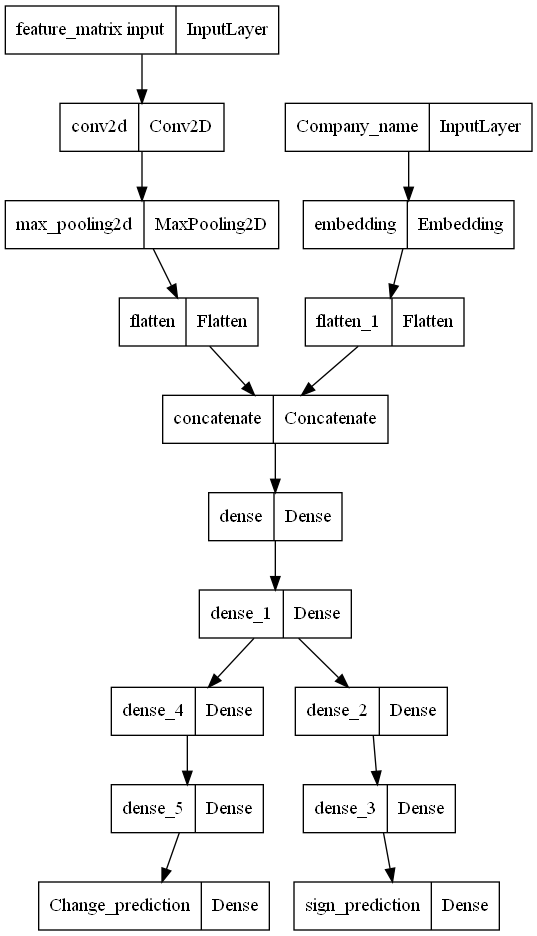

In [12]:
# Plotting model with text input and two outputs
tf.keras.utils.plot_model(model,to_file='base_model.png')

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 feature_matrix input (InputLay  [(None, 500, 310, 1  0          []                               
 er)                            )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 498, 308, 64  640         ['feature_matrix input[0][0]']   
                                )                                                                 
                                                                                                  
 Company_name (InputLayer)      [(None, 1)]          0           []                               
                                                                                              

In [14]:
class RecordEpochInformation(tf.keras.callbacks.Callback):
    """
        Accuracy and Loss will recorded with this callback while training
    """
    def on_train_begin(self, logs={}):
            self.loss = []
            self.Change_prediction_loss = []
            self.sign_prediction_loss = []
            self.val_loss = []
            self.val_Change_prediction_loss = []
            self.val_sign_prediction_loss = []
    
    
    def on_epoch_end(self, epoch, logs={}):
        self.loss.append(logs.get('loss'))
        self.Change_prediction_loss.append(logs.get('Change_prediction_loss'))
        self.sign_prediction_loss.append(logs.get('sign_prediction_loss'))
        self.val_loss.append(logs.get('val_loss'))
        self.val_Change_prediction_loss.append(logs.get('val_Change_prediction_loss'))
        self.val_sign_prediction_loss.append(logs.get('val_sign_prediction_loss'))
        
# Creating RecordEpochInformation class object to record info while training
log_info = RecordEpochInformation()

In [24]:
# Creating RecordEpochInformation class object to record info while training
log_info = RecordEpochInformation()

model.fit([x_train_feat,train_comp],[y_train_change,y_train_sign],
          epochs=5,validation_data=([x_test_feat,test_comp],[y_test_change,y_test_sign]),
         callbacks=[log_info,checkpoint])

Epoch 1/5
303/303 [==============================] - ETA: 0s - loss: 2.2095 - Change_prediction_loss: 1.6197 - sign_prediction_loss: 0.5898
Epoch 00001: val_loss improved from inf to 2.29173, saving model to model1_save\weights-01-2.2917.hdf5
303/303 [==============================] - 648s 2s/step - loss: 2.2095 - Change_prediction_loss: 1.6197 - sign_prediction_loss: 0.5898 - val_loss: 2.2917 - val_Change_prediction_loss: 1.6093 - val_sign_prediction_loss: 0.6825
Epoch 2/5
303/303 [==============================] - ETA: 0s - loss: 1.8293 - Change_prediction_loss: 1.2684 - sign_prediction_loss: 0.5609
Epoch 00002: val_loss did not improve from 2.29173
303/303 [==============================] - 601s 2s/step - loss: 1.8293 - Change_prediction_loss: 1.2684 - sign_prediction_loss: 0.5609 - val_loss: 2.3960 - val_Change_prediction_loss: 1.7608 - val_sign_prediction_loss: 0.6352
Epoch 3/5
303/303 [==============================] - ETA: 0s - loss: 1.6592 - Change_prediction_loss: 1.1329 - sig

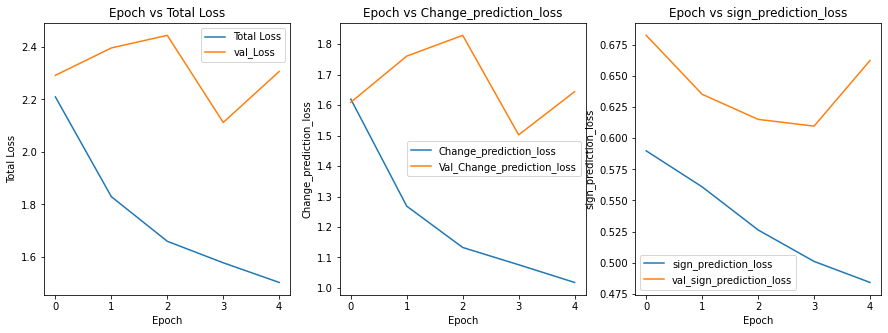

In [25]:
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.plot(log_info.loss,label='Total Loss')
plt.plot(log_info.val_loss,label='val_Loss')
plt.xlabel("Epoch")
plt.ylabel("Total Loss")
plt.title("Epoch vs Total Loss")
plt.legend()

plt.subplot(132)
plt.plot(log_info.Change_prediction_loss,label='Change_prediction_loss')
plt.plot(log_info.val_Change_prediction_loss,label='Val_Change_prediction_loss')
plt.xlabel("Epoch")
plt.ylabel("Change_prediction_loss")
plt.title("Epoch vs Change_prediction_loss")
plt.legend()

plt.subplot(133)
plt.plot(log_info.sign_prediction_loss,label='sign_prediction_loss')
plt.plot(log_info.val_sign_prediction_loss,label='val_sign_prediction_loss')
plt.xlabel("Epoch")
plt.ylabel("sign_prediction_loss")
plt.title("Epoch vs sign_prediction_loss")
plt.legend()

plt.show()

In [17]:
model.load_weights("model1_save\weights-04-2.1121.hdf5")

prediction = model.predict([x_test_feat,test_comp])

deviation = []
for i in range(len(prediction[0])):
    deviation.append(abs(prediction[0][i]-y_test_change[i]))
print("Mean Deviation for % change in closing prices is : ",np.mean(deviation))

count = 0
sign_pred = [1 if i[0]>=0.5 else 0 for i in prediction[1]]
for i in range(0,len(prediction[1])):
    if sign_pred[i] == y_test_sign[i]:
        count += 1
        
print("Number of correct signs predicted out of {} are : {}".format(len(y_test_sign),count))

Mean Deviation for % change in closing prices is :  0.75145924
Number of correct signs predicted out of 1284 are : 866


## 3. Model trained with Both Tweet text and Feature Matrix

In [23]:
from tensorflow.keras.callbacks import ModelCheckpoint

filepath="model3_save/weights-{epoch:02d}-{val_loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss',  verbose=1, save_best_only=True, mode='auto')

In [24]:
np.random.seed(0)
tf.random.set_seed(0)

# clearing previous session if it exists.
tf.keras.backend.clear_session()

# essay feature
input_text = Input(shape=(5000,),name="Tweet text input")

embedding_text = Embedding(vocab_size_text, 100)(input_text)

conv1 = Conv1D(64,kernel_size = 20)(embedding_text)

maxpool1 = MaxPooling1D(10)(conv1)

flatten1 = Flatten()(maxpool1)


input_feat = Input(shape=(500,310,1),name="feature_matrix input")

conv = Conv2D(64,(3,3))(input_feat)

pool = MaxPooling2D()(conv)

flatten2 = Flatten()(pool)

input_company = Input(shape=(1,),name="Company_name")

embedding_company = Embedding(vocab_size_company, 6)(input_company)

flatten3 = Flatten()(embedding_company)


concat = Concatenate()([flatten1,flatten2,flatten3])

dense_layer1 = Dense(50,activation='relu',kernel_initializer=tf.keras.initializers.he_uniform())(concat)

dense_layer2 = Dense(50,activation='relu',kernel_initializer=tf.keras.initializers.he_uniform())(dense_layer1)


dense_layer41 = Dense(50,activation='relu',kernel_initializer=tf.keras.initializers.he_uniform())(dense_layer2)

dense_layer41 = Dense(50,activation='relu',kernel_initializer=tf.keras.initializers.he_uniform())(dense_layer41)

output_sign = Dense(1,activation = 'sigmoid',name="sign_prediction")(dense_layer41)

dense_layer42 = Dense(50,activation='relu',kernel_initializer=tf.keras.initializers.he_uniform())(dense_layer2)

dense_layer42 = Dense(50,activation='relu',kernel_initializer=tf.keras.initializers.he_uniform())(dense_layer42)

output_change = Dense(1,activation='relu',name="Change_prediction")(dense_layer42)


model = Model(inputs=[input_text,input_feat,input_company]
              ,outputs=[output_change,output_sign])

In [25]:
# Referred and implemented Piece wise Decay using below link
# https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/PiecewiseConstantDecay


step = tf.Variable(0, trainable=False)   # Variable to store and get step number in training

# some numbers are multiples of 301 cause these are steps per epoch with batch size 32
boundaries = [10,50,100, 602, 903]
values = [1e-6,1e-5, 1e-4, 1e-4, 0.5e-4, 1e-5]
learning_rate_fn = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries, values)
learn_rate = learning_rate_fn(step)


adamw_opt = tfa.optimizers.AdamW(learning_rate=learn_rate,weight_decay=0.0001)


# compiling with adam optimizer and loss as categorical crossentropy
model.compile(optimizer=adamw_opt,
              loss=[tf.keras.losses.mean_squared_error,tf.keras.losses.binary_crossentropy])

<li> With the definition stated above for learning rate scheduler, the LR will vary according to the table given below: </li>
<table>
    <tr> 
        <td> <b> Steps </b> </td>
        <td> <b> Learning rate </b> </td>
    </tr>
    <tr> 
        <td> 0-10 </td>
        <td> 1e-6 </td>
    </tr>
     <tr> 
        <td> 10-50 </td>
        <td> 1e-5 </td>
    </tr>
    <tr> 
        <td> 51-602 </td>
        <td> 1e-4 </td>
    </tr>
    <tr> 
        <td> 603-903 </td>
        <td> 0.5e-4 </td>
    </tr>
    <tr> 
        <td> 904-end </td>
        <td> 1e-5 </td>
    </tr>
</table>
<li> We can observe with this learning rate variation, we can achieve the LR warm up steps and then learning decay with each epoch. The decay was stopped at 1e-5 value since, no update observed beyond this LR value. </li>

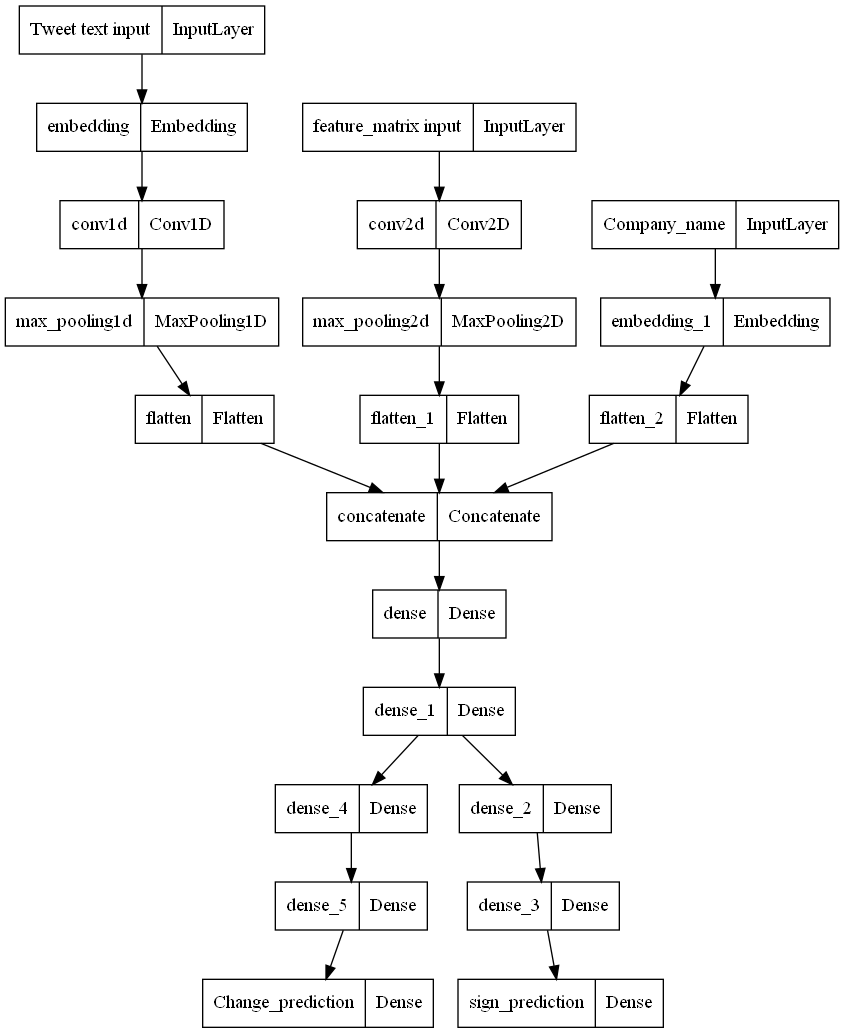

In [26]:
# Plotting model with text input and two outputs
tf.keras.utils.plot_model(model)

In [31]:
model.fit([train_text,x_train_feat,train_comp],[y_train_change,y_train_sign],batch_size=32,
          epochs=7,validation_data=([test_text,x_test_feat,test_comp],[y_test_change,y_test_sign]),
         callbacks=[log_info,checkpoint])

Epoch 1/7
303/303 [==============================] - ETA: 0s - loss: 2.1448 - Change_prediction_loss: 1.4633 - sign_prediction_loss: 0.6815
Epoch 00001: val_loss improved from inf to 2.67870, saving model to model3_save\weights-01-2.6787.hdf5
303/303 [==============================] - 913s 3s/step - loss: 2.1448 - Change_prediction_loss: 1.4633 - sign_prediction_loss: 0.6815 - val_loss: 2.6787 - val_Change_prediction_loss: 2.0099 - val_sign_prediction_loss: 0.6688
Epoch 2/7
303/303 [==============================] - ETA: 0s - loss: 2.0057 - Change_prediction_loss: 1.3472 - sign_prediction_loss: 0.6585
Epoch 00002: val_loss improved from 2.67870 to 2.32682, saving model to model3_save\weights-02-2.3268.hdf5
303/303 [==============================] - 908s 3s/step - loss: 2.0057 - Change_prediction_loss: 1.3472 - sign_prediction_loss: 0.6585 - val_loss: 2.3268 - val_Change_prediction_loss: 1.6835 - val_sign_prediction_loss: 0.6433
Epoch 3/7
303/303 [==============================] - ETA: 

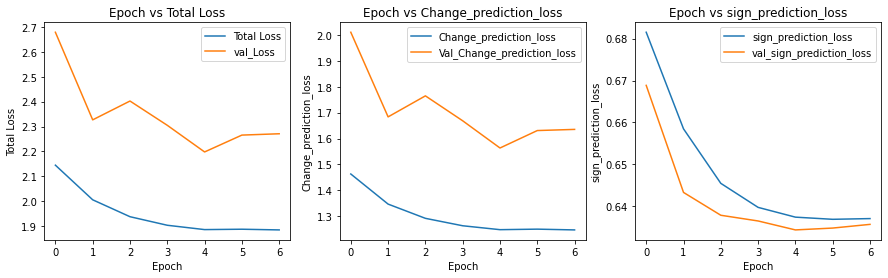

In [32]:
plt.figure(figsize=(15, 4))
plt.subplot(131)
plt.plot(log_info.loss,label='Total Loss')
plt.plot(log_info.val_loss,label='val_Loss')

plt.xlabel("Epoch")
plt.ylabel("Total Loss")
plt.title("Epoch vs Total Loss")
plt.legend()

plt.subplot(132)
plt.plot(log_info.Change_prediction_loss,label='Change_prediction_loss')
plt.plot(log_info.val_Change_prediction_loss,label='Val_Change_prediction_loss')
plt.xlabel("Epoch")
plt.ylabel("Change_prediction_loss")
plt.title("Epoch vs Change_prediction_loss")
plt.legend()

plt.subplot(133)
plt.plot(log_info.sign_prediction_loss,label='sign_prediction_loss')
plt.plot(log_info.val_sign_prediction_loss,label='val_sign_prediction_loss')
plt.xlabel("Epoch")
plt.ylabel("sign_prediction_loss")
plt.title("Epoch vs sign_prediction_loss")
plt.legend()

plt.show()

In [27]:
model.load_weights('model3_save\weights-05-2.1979.hdf5')

prediction = model.predict([test_text,x_test_feat,test_comp])

deviation = []
for i in range(len(prediction[0])):
    deviation.append(abs(prediction[0][i]-y_test_change[i]))
print("Mean Deviation for % change in closing prices is : ",np.mean(deviation))

count = 0
sign_pred = [1 if i[0]>=0.5 else 0 for i in prediction[1]]
for i in range(0,len(prediction[1])):
    if sign_pred[i] == y_test_sign[i]:
        count += 1
        
print("Number of correct signs predicted out of {} are : {}".format(len(y_test_sign),count))

Mean Deviation for % change in closing prices is :  0.86987495
Number of correct signs predicted out of 1284 are : 872


## 4. Multichannel Convolution Neural Network Model with both tweet text and feature matrix

<li> This network model was discussed with one of the research papers in abstract. </li>
<li> Here multichannel means parallel branches of convolution neural networks. </li>
<li> We saw the minimum deviation from actual was observed with tweet text input model while maximum number of correct sign prediction was observed with feature matrix model. Here this model will have parallel branches of CNN with text inputs </li>

In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint

filepath="model4_save/weights-{epoch:02d}-{val_loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss',  verbose=1, save_best_only=True, mode='auto')

In [22]:
np.random.seed(0)
tf.random.set_seed(0)

# clearing previous session if it exists.
tf.keras.backend.clear_session()

# essay feature
input_text = Input(shape=(5000,),name="Tweet text input")

embedding_text = Embedding(vocab_size_text, 100)(input_text)


conv11 = Conv1D(64,kernel_size = 20,padding='same')(embedding_text)

maxpool11 = MaxPooling1D(10)(conv11)


conv12 = Conv1D(64,kernel_size = 10,padding='same')(embedding_text)

maxpool12 = MaxPooling1D(10)(conv12)


concat1 = Concatenate()([maxpool11,maxpool12])

flatten1 = Flatten()(concat1)



input_feat = Input(shape=(500,310,1),name="feature_matrix input")

conv21 = Conv2D(64,(3,3),padding='same')(input_feat)

pool21 = MaxPooling2D()(conv21)

flatten2 = Flatten()(pool21)



input_company = Input(shape=(1,),name="Company_name")

embedding_company = Embedding(vocab_size_company, 6)(input_company)

flatten3 = Flatten()(embedding_company)



concat = Concatenate()([flatten1,flatten2,flatten3])

dense_layer1 = Dense(50,activation='relu',kernel_initializer=tf.keras.initializers.he_uniform())(concat)

dense_layer2 = Dense(50,activation='relu',kernel_initializer=tf.keras.initializers.he_uniform())(dense_layer1)

dense_layer3 = Dense(50,activation='relu',kernel_initializer=tf.keras.initializers.he_uniform())(dense_layer2)

dense_layer4 = Dense(50,activation='relu',kernel_initializer=tf.keras.initializers.he_uniform())(dense_layer3)

dense_layer41 = Dense(50,activation='relu',kernel_initializer=tf.keras.initializers.he_uniform())(dense_layer4)

dense_layer41 = Dense(50,activation='relu',kernel_initializer=tf.keras.initializers.he_uniform())(dense_layer41)

output_sign = Dense(1,activation = 'sigmoid',name="sign_prediction")(dense_layer41)

dense_layer42 = Dense(50,activation='relu',kernel_initializer=tf.keras.initializers.he_uniform())(dense_layer4)

dense_layer42 = Dense(50,activation='relu',kernel_initializer=tf.keras.initializers.he_uniform())(dense_layer42)

output_change = Dense(1,activation='relu',name="Change_prediction")(dense_layer42)


model = Model(inputs=[input_text,input_feat,input_company]
              ,outputs=[output_change,output_sign])

In [23]:
# Referred and implemented Piece wise Decay using below link
# https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/PiecewiseConstantDecay


step = tf.Variable(0, trainable=False)   # Variable to store and get step number in training

# some numbers are multiples of 301 cause these are steps per epoch with batch size 32
boundaries = [10,50,100, 602, 903]
values = [1e-6,1e-5, 1e-4, 1e-4, 0.5e-4, 1e-5]
learning_rate_fn = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries, values)
learn_rate = learning_rate_fn(step)


adamw_opt = tfa.optimizers.AdamW(learning_rate=learn_rate,weight_decay=0.0001)


# compiling with adam optimizer and loss as categorical crossentropy
model.compile(optimizer=adamw_opt,
              loss=[tf.keras.losses.mean_squared_error,tf.keras.losses.binary_crossentropy])

<li> With the definition stated above for learning rate scheduler, the LR will vary according to the table given below: </li>
<table>
    <tr> 
        <td> <b> Steps </b> </td>
        <td> <b> Learning rate </b> </td>
    </tr>
    <tr> 
        <td> 0-10 </td>
        <td> 1e-6 </td>
    </tr>
     <tr> 
        <td> 10-50 </td>
        <td> 1e-5 </td>
    </tr>
    <tr> 
        <td> 51-602 </td>
        <td> 1e-4 </td>
    </tr>
    <tr> 
        <td> 603-903 </td>
        <td> 0.5e-4 </td>
    </tr>
    <tr> 
        <td> 904-end </td>
        <td> 1e-5 </td>
    </tr>
</table>
<li> We can observe with this learning rate variation, we can achieve the LR warm up steps and then learning decay with each epoch. The decay was stopped at 1e-5 value since, no update observed beyond this LR value. </li>

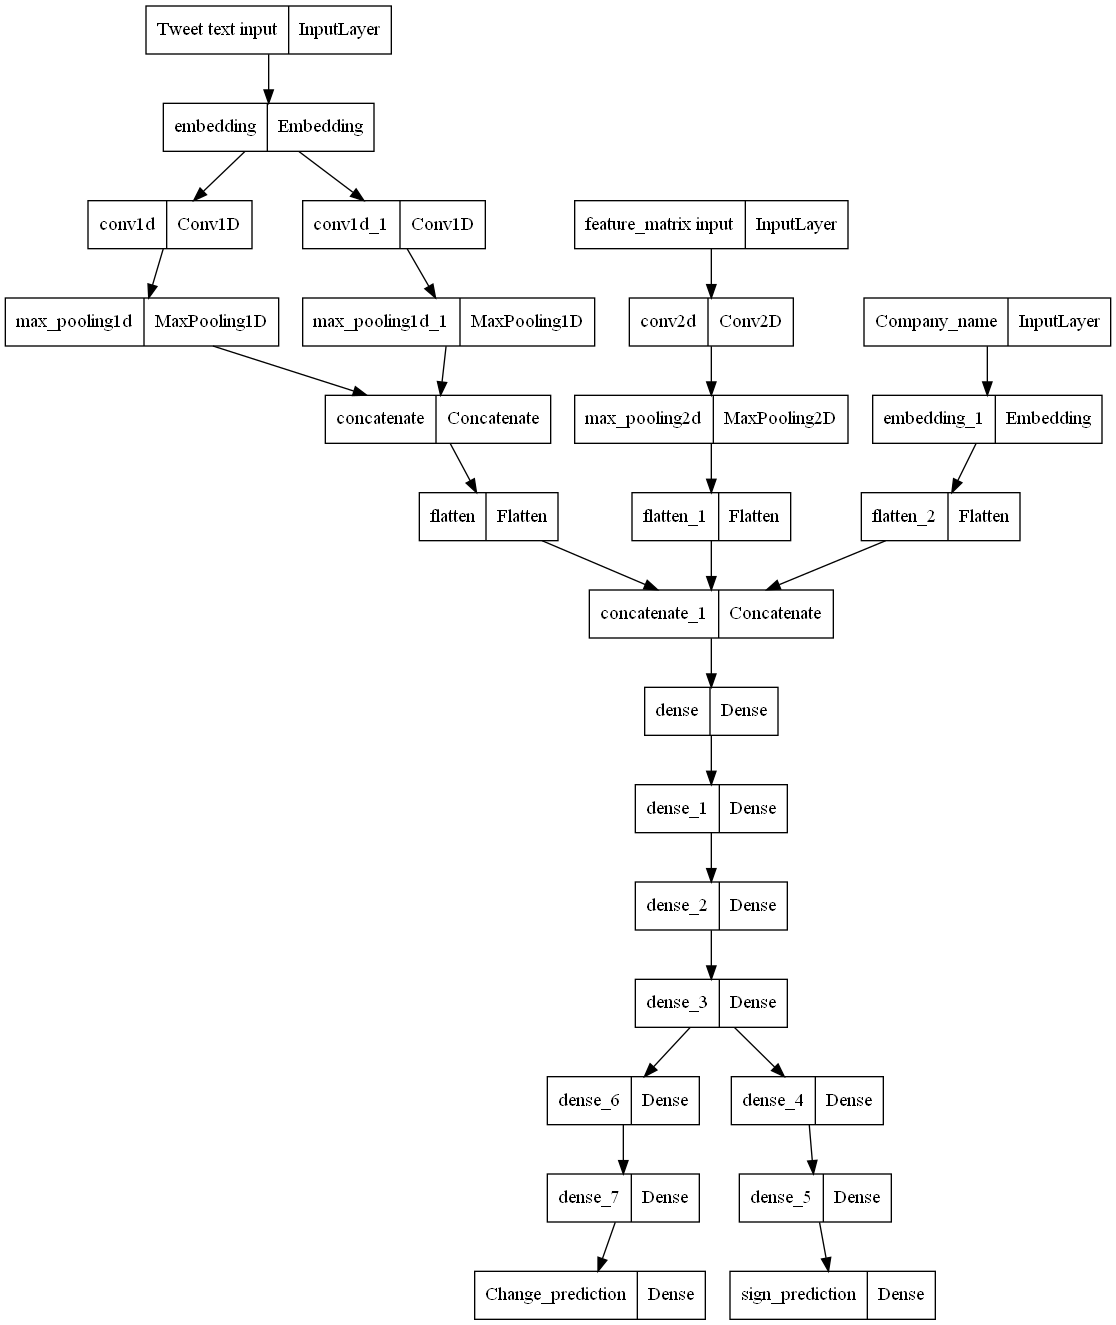

In [24]:
# Plotting model with text input and two outputs
tf.keras.utils.plot_model(model,to_file='best_model.png')

In [25]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Tweet text input (InputLayer)  [(None, 5000)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 5000, 100)    701100      ['Tweet text input[0][0]']       
                                                                                                  
 conv1d (Conv1D)                (None, 5000, 64)     128064      ['embedding[0][0]']              
                                                                                                  
 conv1d_1 (Conv1D)              (None, 5000, 64)     64064       ['embedding[0][0]']              
                                                                                              

In [26]:
class RecordEpochInformation(tf.keras.callbacks.Callback):
    """
        Accuracy and Loss will recorded with this callback while training
    """
    def on_train_begin(self, logs={}):
            self.loss = []
            self.Change_prediction_loss = []
            self.sign_prediction_loss = []
            self.val_loss = []
            self.val_Change_prediction_loss = []
            self.val_sign_prediction_loss = []
    
    
    def on_epoch_end(self, epoch, logs={}):
        self.loss.append(logs.get('loss'))
        self.Change_prediction_loss.append(logs.get('Change_prediction_loss'))
        self.sign_prediction_loss.append(logs.get('sign_prediction_loss'))
        self.val_loss.append(logs.get('val_loss'))
        self.val_Change_prediction_loss.append(logs.get('val_Change_prediction_loss'))
        self.val_sign_prediction_loss.append(logs.get('val_sign_prediction_loss'))
        
# Creating RecordEpochInformation class object to record info while training
log_info = RecordEpochInformation()

In [40]:
# Creating RecordEpochInformation class object to record info while training
log_info = RecordEpochInformation()

model.fit([train_text,x_train_feat,train_comp],[y_train_change,y_train_sign],
          epochs=6,validation_data=([test_text,x_test_feat,test_comp],[y_test_change,y_test_sign]),
         callbacks=[log_info,checkpoint])

Epoch 1/6
303/303 [==============================] - ETA: 0s - loss: 2.1566 - Change_prediction_loss: 1.4995 - sign_prediction_loss: 0.6571
Epoch 00001: val_loss improved from inf to 2.58554, saving model to model4_save\weights-01-2.5855.hdf5
303/303 [==============================] - 1038s 3s/step - loss: 2.1566 - Change_prediction_loss: 1.4995 - sign_prediction_loss: 0.6571 - val_loss: 2.5855 - val_Change_prediction_loss: 1.9310 - val_sign_prediction_loss: 0.6546
Epoch 2/6
303/303 [==============================] - ETA: 0s - loss: 1.9927 - Change_prediction_loss: 1.3656 - sign_prediction_loss: 0.6271
Epoch 00002: val_loss improved from 2.58554 to 2.31907, saving model to model4_save\weights-02-2.3191.hdf5
303/303 [==============================] - 1084s 4s/step - loss: 1.9927 - Change_prediction_loss: 1.3656 - sign_prediction_loss: 0.6271 - val_loss: 2.3191 - val_Change_prediction_loss: 1.6871 - val_sign_prediction_loss: 0.6320
Epoch 3/6
303/303 [==============================] - ETA

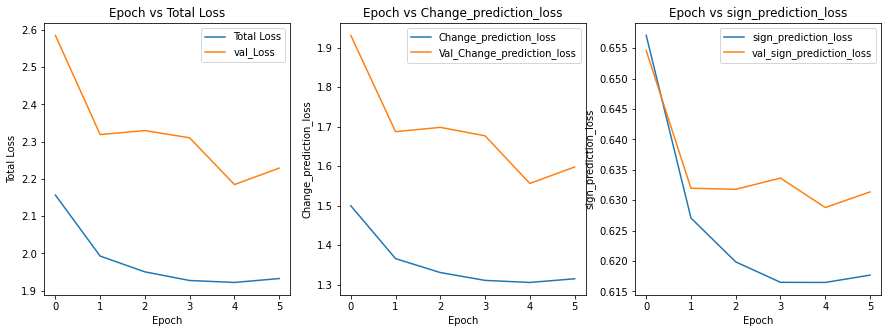

In [41]:
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.plot(log_info.loss,label='Total Loss')
plt.plot(log_info.val_loss,label='val_Loss')
plt.xlabel("Epoch")
plt.ylabel("Total Loss")
plt.title("Epoch vs Total Loss")
plt.legend()

plt.subplot(132)
plt.plot(log_info.Change_prediction_loss,label='Change_prediction_loss')
plt.plot(log_info.val_Change_prediction_loss,label='Val_Change_prediction_loss')
plt.xlabel("Epoch")
plt.ylabel("Change_prediction_loss")
plt.title("Epoch vs Change_prediction_loss")
plt.legend()

plt.subplot(133)
plt.plot(log_info.sign_prediction_loss,label='sign_prediction_loss')
plt.plot(log_info.val_sign_prediction_loss,label='val_sign_prediction_loss')
plt.xlabel("Epoch")
plt.ylabel("sign_prediction_loss")
plt.title("Epoch vs sign_prediction_loss")
plt.legend()

plt.show()

In [27]:
model.load_weights('model4_save\weights-05-2.1848.hdf5')

prediction = model.predict([test_text,x_test_feat,test_comp])

deviation = []
for i in range(len(prediction[0])):
    deviation.append(abs(prediction[0][i]-y_test_change[i]))
print("Mean Deviation for % change in closing prices is : ",np.mean(deviation))

count = 0
sign_pred = [1 if i[0]>=0.5 else 0 for i in prediction[1]]
for i in range(0,len(prediction[1])):
    if sign_pred[i] == y_test_sign[i]:
        count += 1
        
print("Number of correct signs predicted out of {} are : {}".format(len(y_test_sign),count))
print("The ratio of correct predictions is : ",count/len(sign_pred))

Mean Deviation for % change in closing prices is :  0.85438716
Number of correct signs predicted out of 1284 are : 888
The ratio of correct predictions is :  0.6915887850467289


## 5. Multichannel Convolution Neural Network Model with just tweet text

In [35]:
from tensorflow.keras.callbacks import ModelCheckpoint

filepath="model5_save/weights-{epoch:02d}-{val_loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss',  verbose=1, save_best_only=True, mode='auto')

In [40]:
np.random.seed(0)
tf.random.set_seed(0)

# clearing previous session if it exists.
tf.keras.backend.clear_session()

# essay feature
input_text = Input(shape=(5000,),name="Tweet text input")

embedding_text = Embedding(vocab_size_text, 100)(input_text)


conv11 = Conv1D(64,kernel_size = 20,padding='same')(embedding_text)

maxpool11 = MaxPooling1D(10)(conv11)


conv12 = Conv1D(64,kernel_size = 10,padding='same')(embedding_text)

maxpool12 = MaxPooling1D(10)(conv12)

conv13 = Conv1D(64,kernel_size = 5,padding='same')(embedding_text)

maxpool13 = MaxPooling1D(10)(conv12)


concat1 = Concatenate()([maxpool11,maxpool12,maxpool13])

flatten1 = Flatten()(concat1)


input_company = Input(shape=(1,),name="Company_name")

embedding_company = Embedding(vocab_size_company, 6)(input_company)

flatten2 = Flatten()(embedding_company)



concat = Concatenate()([flatten1,flatten2])

dense_layer1 = Dense(50,activation='relu',kernel_initializer=tf.keras.initializers.he_uniform())(concat)

dense_layer2 = Dense(50,activation='relu',kernel_initializer=tf.keras.initializers.he_uniform())(dense_layer1)

dense_layer3 = Dense(50,activation='relu',kernel_initializer=tf.keras.initializers.he_uniform())(dense_layer2)

dense_layer4 = Dense(50,activation='relu',kernel_initializer=tf.keras.initializers.he_uniform())(dense_layer3)

dense_layer41 = Dense(50,activation='relu',kernel_initializer=tf.keras.initializers.he_uniform())(dense_layer4)

dense_layer41 = Dense(50,activation='relu',kernel_initializer=tf.keras.initializers.he_uniform())(dense_layer41)

output_sign = Dense(1,activation = 'sigmoid',name="sign_prediction")(dense_layer41)

dense_layer42 = Dense(50,activation='relu',kernel_initializer=tf.keras.initializers.he_uniform())(dense_layer4)

dense_layer42 = Dense(50,activation='relu',kernel_initializer=tf.keras.initializers.he_uniform())(dense_layer42)

output_change = Dense(1,activation='relu',name="Change_prediction")(dense_layer42)


model = Model(inputs=[input_text,input_company]
              ,outputs=[output_change,output_sign])

# compiling with adam optimizer and loss as categorical crossentropy
model.compile(optimizer=tf.keras.optimizers.Adam(0.0001),
              loss=[tf.keras.losses.mean_squared_error,tf.keras.losses.binary_crossentropy])

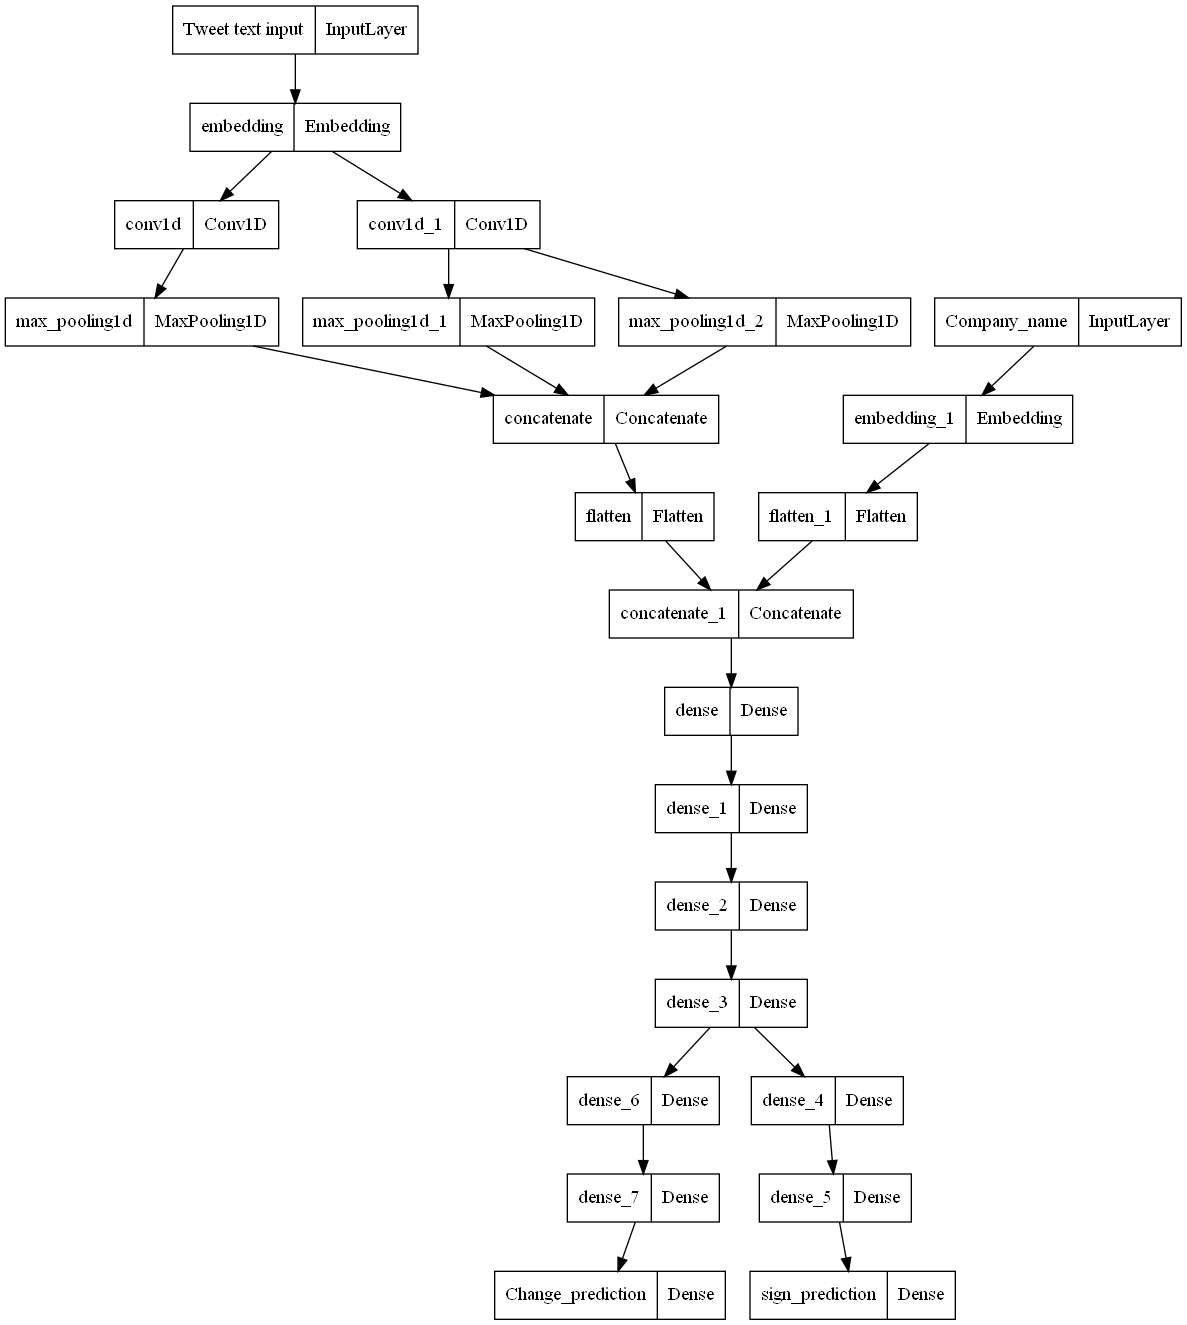

In [41]:
# Plotting model with text input and two outputs
tf.keras.utils.plot_model(model)

In [42]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Tweet text input (InputLayer)  [(None, 5000)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 5000, 100)    701100      ['Tweet text input[0][0]']       
                                                                                                  
 conv1d (Conv1D)                (None, 5000, 64)     128064      ['embedding[0][0]']              
                                                                                                  
 conv1d_1 (Conv1D)              (None, 5000, 64)     64064       ['embedding[0][0]']              
                                                                                              

In [43]:
class RecordEpochInformation(tf.keras.callbacks.Callback):
    """
        Accuracy and Loss will recorded with this callback while training
    """
    def on_train_begin(self, logs={}):
            self.loss = []
            self.Change_prediction_loss = []
            self.sign_prediction_loss = []
            self.val_loss = []
            self.val_Change_prediction_loss = []
            self.val_sign_prediction_loss = []
    
    
    def on_epoch_end(self, epoch, logs={}):
        self.loss.append(logs.get('loss'))
        self.Change_prediction_loss.append(logs.get('Change_prediction_loss'))
        self.sign_prediction_loss.append(logs.get('sign_prediction_loss'))
        self.val_loss.append(logs.get('val_loss'))
        self.val_Change_prediction_loss.append(logs.get('val_Change_prediction_loss'))
        self.val_sign_prediction_loss.append(logs.get('val_sign_prediction_loss'))
        
# Creating RecordEpochInformation class object to record info while training
log_info = RecordEpochInformation()

In [26]:
# Creating RecordEpochInformation class object to record info while training
log_info = RecordEpochInformation()

model.fit([train_text,train_comp],[y_train_change,y_train_sign],
          epochs=5,validation_data=([test_text,test_comp],[y_test_change,y_test_sign]),
         callbacks=[log_info,checkpoint])

Epoch 1/5
303/303 [==============================] - ETA: 0s - loss: 2.0911 - Change_prediction_loss: 1.4849 - sign_prediction_loss: 0.6062
Epoch 00001: val_loss improved from inf to 2.28737, saving model to model5_save\weights-01-2.2874.hdf5
303/303 [==============================] - 43s 136ms/step - loss: 2.0911 - Change_prediction_loss: 1.4849 - sign_prediction_loss: 0.6062 - val_loss: 2.2874 - val_Change_prediction_loss: 1.6589 - val_sign_prediction_loss: 0.6285
Epoch 2/5
302/303 [============================>.] - ETA: 0s - loss: 1.9361 - Change_prediction_loss: 1.3517 - sign_prediction_loss: 0.5845
Epoch 00002: val_loss improved from 2.28737 to 2.28364, saving model to model5_save\weights-02-2.2836.hdf5
303/303 [==============================] - 41s 134ms/step - loss: 1.9355 - Change_prediction_loss: 1.3510 - sign_prediction_loss: 0.5845 - val_loss: 2.2836 - val_Change_prediction_loss: 1.6347 - val_sign_prediction_loss: 0.6490
Epoch 3/5
302/303 [============================>.] - E

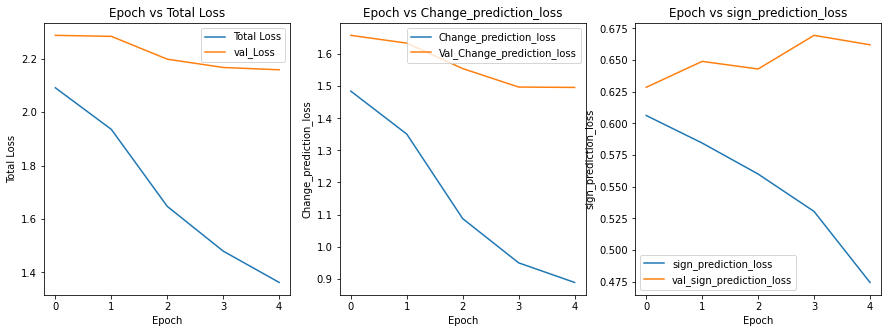

In [27]:
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.plot(log_info.loss,label='Total Loss')
plt.plot(log_info.val_loss,label='val_Loss')
plt.xlabel("Epoch")
plt.ylabel("Total Loss")
plt.title("Epoch vs Total Loss")
plt.legend()

plt.subplot(132)
plt.plot(log_info.Change_prediction_loss,label='Change_prediction_loss')
plt.plot(log_info.val_Change_prediction_loss,label='Val_Change_prediction_loss')
plt.xlabel("Epoch")
plt.ylabel("Change_prediction_loss")
plt.title("Epoch vs Change_prediction_loss")
plt.legend()

plt.subplot(133)
plt.plot(log_info.sign_prediction_loss,label='sign_prediction_loss')
plt.plot(log_info.val_sign_prediction_loss,label='val_sign_prediction_loss')
plt.xlabel("Epoch")
plt.ylabel("sign_prediction_loss")
plt.title("Epoch vs sign_prediction_loss")
plt.legend()

plt.show()

In [28]:
prediction = model.predict([test_text,test_comp])

deviation = []
for i in range(len(prediction[0])):
    deviation.append(abs(prediction[0][i]-y_test_change[i]))
print("Mean Deviation for % change in closing prices is : ",np.mean(deviation))

count = 0
sign_pred = [1 if i[0]>=0.5 else 0 for i in prediction[1]]
for i in range(0,len(prediction[1])):
    if sign_pred[i] == y_test_sign[i]:
        count += 1
        
print("Number of correct signs predicted out of {} are : {}".format(len(y_test_sign),count))

Mean Deviation for % change in closing prices is :  0.80678344
Number of correct signs predicted out of 1284 are : 765


# Summary of Model Training

<table>
    <tr>
        <td><b> Sr. No. </b> </td>
        <td><b>Model</b></td>
        <td><b>Inputs</b></td>
        <td><b>Outputs</b></td>
        <td><b>Min val_change_prediction loss</b></td>
        <td><b>Min val_sign_prediction loss</b></td>
        <td><b>Mean deviation from actual values</b></td>
        <td><b>Correct signs predicted out of 1282</b></td>
    </tr>
    <tr>
        <td>1. </td>
        <td>Base model trained with just Combined Tweet Text Data</td>
        <td>input_feat,input_company</td>
        <td>output_change, output_sign</td>
        <td> 1.4636</td>
        <td>0.6525</td>
        <td>0.7918114</td>
        <td>782</td>
    </tr>
    <tr>
        <td>2. </td>
        <td>Model trained with just Feature Matrix</td>
        <td> input_text,input_company </td>
        <td>output_change, output_sign</td>
        <td>1.5024</td>
        <td>0.6096</td>
        <td>0.75145924</td>
        <td>866</td>
    </tr>
    <tr>
        <td>3. </td>
        <td>Model trained with Both Tweet text and Feature Matrix</td>
        <td> input_text,input_feat,input_company </td>
        <td>output_change, output_sign</td>
        <td>1.5635 </td>
        <td>0.6344</td>
        <td>0.86987495</td>
        <td>872</td>
    </tr>
    <tr>
        <td>4. </td>
        <td>Multichannel Convolution Neural Network Model with both tweet text and feature matrix</td>
        <td> input_text,input_feat,input_company </td>
        <td>output_change, output_sign</td>
        <td> 1.5560 </td>
        <td>0.6288</td>
        <td>0.85519534</td>
        <td>888</td>
    </tr>
    <tr>
        <td>5. </td>
        <td>Multichannel Convolution Neural Network Model with just tweet text</td>
        <td> input_text,input_feat,input_company </td>
        <td>output_change, output_sign</td>
        <td> 1.4964  </td>
        <td> 0.6621 </td>
        <td> 0.80678344 </td>
        <td> 765 </td>
    </tr>
</table>

## Observations and Conclusions

### Observations with Trained models

<li> With reference to the table stated above, we can observe that models with just tweet text as inputs are performing better when compared to just feature matrix input when we consider "val_change_prediction" loss. While models with just feature matrix as inputs are performing better with respect to sign prediction. Hence we can observe if we combine both text input and feature matrix in model 3 & 4 then we are able to get low "val_change_prediction" loss. </li>
<li> The mean deviation is the mean of deviation from actual % change values. This was having least value for model 3 with both text as input and feature matrix as input. </li>
<li> But if we consider both mean deviation and sign predictions, then Multichannel CNNs i.e. model 4 is performing better. Hence this can be considered as the best performing model. </li>

### Conclusion

<li> We can see that, these trained models are able to predict the stock market price variations and their signs to some extent based on tweets so twitter does have an impact on Stock market price variations. </li>
<li> But we should also note that twitter is not the only one social media platform on which users express their thoughts. Other platforms such as Facebook, Whatsapp, News platforms or even Youtube will have an impact on Stock market. </li>
<li> Hence based on these tweets we are able to predict one aspect of stock market price variations and if we include other platform data as well then the prediction will definitely increase to a great extent. </li>